In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv('Sales-Data-mod.csv').dropna(how="all").reset_index(drop=True)

## Data Preparation

Remove entries that shows inventory is out-of-stock, as sales does not present demand and we want demand estimation.

In [3]:
data_input = data[data['Inventory Flag']==0]

In [30]:
data_input

,Item,Week,Price,Sales,Remaining Inventory,Inventory Flag,Price Change Flag,Scenario
0,1,1,60,57,1943,0,0,7
1,1,2,60,98,1845,0,0,7
2,1,3,60,55,1790,0,0,7
3,1,4,60,41,1749,0,0,7
4,1,5,60,60,1689,0,0,7
...,...,...,...,...,...,...,...,...
220,15,11,36,116,1142,0,0,10
221,15,12,36,152,990,0,0,10
222,15,13,36,188,802,0,0,10
223,15,14,36,244,558,0,0,10


In [4]:
data_input.shape

(220, 8)

In [5]:
data_input.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220 entries, 0 to 224
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Item                 220 non-null    int64
 1   Week                 220 non-null    int64
 2   Price                220 non-null    int64
 3   Sales                220 non-null    int64
 4   Remaining Inventory  220 non-null    int64
 5   Inventory Flag       220 non-null    int64
 6   Price Change Flag    220 non-null    int64
 7   Scenario             220 non-null    int64
dtypes: int64(8)
memory usage: 15.5 KB


## Data Discovery

In [6]:
np.unique(data_input.Scenario)

array([ 7,  8, 10])

In [7]:
data_vis = data_input.set_index('Week')

### Scenario 7: Price change at week 7

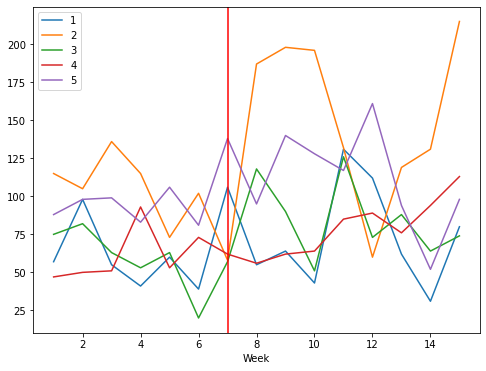

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
data_vis[data_vis.Scenario==7].groupby('Item')['Sales'].plot(legend=True,ax=ax)
plt.axvline(x=7,color="red")

### Scenario 8: Price change at week 8

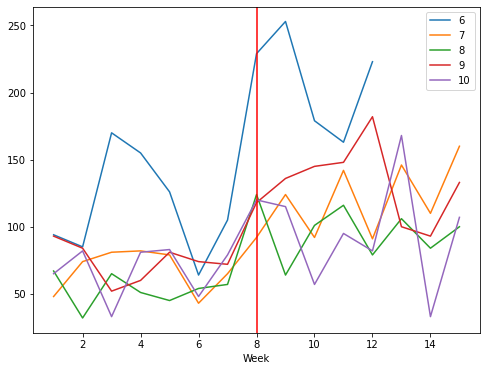

In [9]:
fig, ax = plt.subplots(figsize=(8,6))
data_vis[data_vis.Scenario==8].groupby('Item')['Sales'].plot(legend=True,ax=ax)
plt.axvline(x=8,color="red")

### Scenario 10: Price change at week 10

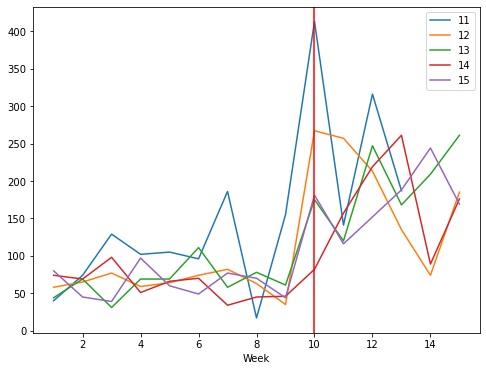

In [10]:
fig, ax = plt.subplots(figsize=(8,6))
data_vis[data_vis.Scenario==10].groupby('Item')['Sales'].plot(legend=True,ax=ax)
plt.axvline(x=10,color="red")

## Demand Function Estimation
From previous visualization we noticed the following:
- Demand is not necessarily linear, constant variance assumption will break
- There is a demand lift whenever there's a price drop
- Given the same price level ($60), demand values fell under a similar range
- After Demand lift, variance of demand distribution tend to increase as well

We can consider regression models for demand estimation. However given the amount of data points we have, model might be overfitted. 

### Two Performance Matrix
- MSE: Prediction error
- R2 score: Capture overfitting behaviours

In [11]:
import statsmodels.api as sm
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense

### Train-test split

In [13]:
X = data_input[['Week','Price','Price Change Flag']]
X.loc[:,'Week'] = X.loc[:,'Week'].astype("category").cat.codes
y = data_input['Sales']

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Baseline: Linear Regression

In [14]:
X_train_cons = sm.add_constant(X_train)
base_linear = sm.OLS(list(y_train), X_train_cons)
base_linear_fitted = base_linear.fit()
print(base_linear_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     44.48
Date:                Sun, 08 May 2022   Prob (F-statistic):           1.27e-20
Time:                        17:32:14   Log-Likelihood:                -785.55
No. Observations:                 154   AIC:                             1579.
Df Residuals:                     150   BIC:                             1591.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               406.7595     38.77

In [15]:
lm_pred = base_linear_fitted.predict(sm.add_constant(X_test))
print("Out of sample R-squared:",r2_score(y_test, lm_pred))
print("MSE:",mean_squared_error(y_test, lm_pred))

Out of sample R-squared: 0.3714325165715864
MSE: 2726.755180157137


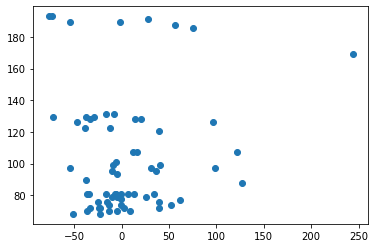

In [31]:
residuals = np.array(y_test) - lm_pred
plt.scatter(residuals,lm_pred)

plt.show()

### AI Methods

In [27]:
def cross_validate_model(model,train_x,train_y, valid_x, valid_y):
    n_scores = cross_val_score(model, train_x,train_y, scoring='neg_mean_squared_error')
    print('Train Set MSE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
    fitted = model.fit(train_x,train_y)
    pred = model.predict(valid_x)
    print('Test Set MSE: %.3f' % (mean_squared_error(valid_y,pred).round(3)))
    print("Test Set out of sample R-squared:",(r2_score(valid_y,pred).round(3)))
    return np.mean(n_scores), np.std(n_scores), mean_squared_error(valid_y,pred)

def sklearn_fit_on_default(train_x,train_y, test_x, test_y):
    ### Machine Learning
    # Random Forest
    print("Random Forest:")
    rf_train_score,rf_train_std,rf_test_score = cross_validate_model(RandomForestRegressor(random_state=1),
                                                                     train_x,train_y, test_x, test_y)
    # Grandient Boosting
    print("Grandient Boosting:")
    gb_train_score,gb_train_std,gb_test_score = cross_validate_model(GradientBoostingRegressor(random_state=1),
                                                                     train_x,train_y, test_x, test_y)
    # LGBM
    print("LGBM:")
    lgbm_train_score,lgbm_train_std,lgbm_test_score = cross_validate_model(LGBMRegressor(random_state=1),
                                                                           train_x,train_y, test_x, test_y)
    # XGBoost
    print("XGBoost:")
    xgb_train_score,xgb_train_std,xgb_test_score = cross_validate_model(XGBRegressor(random_state=1),
                                                                        train_x,train_y, test_x, test_y)
        
    ### Deep Learning (wrap in sklearn fashion)
    # MLP
    print("sklearn MLP:")
    mlp_train_score,mlp_train_std,mlp_test_score = cross_validate_model(MLPRegressor(random_state=1, max_iter=500, hidden_layer_sizes=(20,20,20)),
                                                                        train_x,train_y, test_x, test_y)
    # Tensorflow sequential
    print("Tensorflow sequential:")
    def baseline_model():
        # create model
        model = Sequential()
        model.add(Dense(20, input_dim=train_x.shape[1], activation='relu'))
        model.add(Dense(20, activation='relu'))
        model.add(Dense(20, activation='relu'))
        model.add(Dense(1))
        # Compile model
        model.compile(loss='mean_squared_error', optimizer='adam', metrics=["mse"])
        return model
        
    tf_train_score,tf_train_std,tf_test_score = cross_validate_model(KerasRegressor(model=baseline_model, epochs=500, verbose=0),
                                                                     train_x,train_y, test_x, test_y)
        
    ### result comparison
    result_dict = {'Model':["Random Forest","Grandient Boosting","LGBM","XGBoost","sklearn MLP","Tensorflow sequential"],
                    'Train_score':[rf_train_score,gb_train_score,lgbm_train_score,xgb_train_score,mlp_train_score,tf_train_score],
                    'Train_std':[rf_train_std,gb_train_std,lgbm_train_std,xgb_train_std,mlp_train_std,tf_train_std],
                    'Test_score':[rf_test_score,gb_test_score,lgbm_test_score,xgb_test_score,mlp_test_score,tf_test_score]}
    result_pd = pd.DataFrame(result_dict)
    return result_pd

In [28]:
sklearn_fit_on_default(X_train, y_train, X_test, y_test)

Random Forest:
Train Set MSE: -1990.410 (396.658)
Test Set MSE: 3224.000
Test Set out of sample R-squared: 0.257
Grandient Boosting:
Train Set MSE: -1955.376 (326.189)
Test Set MSE: 3117.583
Test Set out of sample R-squared: 0.281
LGBM:
Train Set MSE: -1941.305 (310.757)
Test Set MSE: 2636.337
Test Set out of sample R-squared: 0.392
XGBoost:
Train Set MSE: -2116.065 (365.281)
Test Set MSE: 3388.276
Test Set out of sample R-squared: 0.219
sklearn MLP:


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multi

Train Set MSE: -2620.836 (381.189)


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Test Set MSE: 3417.300
Test Set out of sample R-squared: 0.212
Tensorflow sequential:
Train Set MSE: -2465.816 (374.953)
Test Set MSE: 3088.513
Test Set out of sample R-squared: 0.288


,Model,Train_score,Train_std,Test_score
0,Random Forest,-1990.409641,396.657826,3224.000060
1,Grandient Boosting,-1955.376477,326.189320,3117.583320
2,LGBM,-1941.304924,310.756644,2636.337225
3,XGBoost,-2116.064611,365.281017,3388.275560
4,sklearn MLP,-2620.836016,381.189224,3417.300256
5,Tensorflow sequential,-2465.815873,374.952746,3088.512665


Optimal model to carry forward: LGBM

### Fine-tuning

In [33]:
import optuna  # pip install optuna
from optuna.integration import LightGBMPruningCallback
from lightgbm import early_stopping

In [38]:
def objective(trial, train_x, test_x, train_y, test_y):
    param_grid = {
        #         "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "verbosity": 0,
        "n_estimators": trial.suggest_int("n_estimators",  200, 5000, step=50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12)
    }
    
    model = LGBMRegressor(objective= "regression", **param_grid)  
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],
              callbacks=[early_stopping(50)])
    preds = model.predict(test_x)
    
    mse = mean_squared_error(test_y, preds)
    
    return mse

### Execute Optuna

In [61]:
optuna.logging.set_verbosity(0)
study = optuna.create_study(direction="minimize", study_name="LGBM Regressor")
func = lambda trial: objective(trial, X_train, X_test, y_train, y_test)
study.optimize(func, n_trials=30, show_progress_bar=False)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

### Fit with best model found 

In [62]:
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

Number of finished trials: 30
Best trial: {'n_estimators': 3300, 'learning_rate': 0.2771728350688154, 'num_leaves': 2460, 'max_depth': 12}


In [63]:
Best_trial = study.best_trial.params

model_opt = LGBMRegressor(**Best_trial)
model_opt.fit(X_train,y_train)
preds = model_opt.predict(X_test)
print("MSE:",mean_squared_error(y_test,preds))
print("R2 score:", r2_score(y_test,preds).round(3))

MSE: 2941.409762238036
R2 score: 0.322


In [64]:
model_default = LGBMRegressor()
model_default.fit(X_train,y_train)
preds = model_default.predict(X_test)
print("MSE:",mean_squared_error(y_test,preds))
print("R2 score:", r2_score(y_test,preds).round(3))

MSE: 2636.337225365947
R2 score: 0.392


Stick with default setting.

In [15]:
model_fin = LGBMRegressor()
model_fin_fitted = model_fin.fit(X,y)

### Save model

In [70]:
import pickle
pickle.dump(model_fin_fitted, open('demand_opt.sav', 'wb'))

In [71]:
X

,Week,Price,Price Change Flag
0,0,60,0
1,1,60,0
2,2,60,0
3,3,60,0
4,4,60,0
...,...,...,...
220,10,36,0
221,11,36,0
222,12,36,0
223,13,36,0


In [75]:
model_fin_fitted.predict([[13,60,1]])[0].round()

67.0

In [17]:
import pickle
load = pickle.load(open('demand_opt.sav', 'rb'))

## Build a look up table for sales forecast based on demand estimation
Given that any solver would have trouble take in decision variables as an input, the optimal solution for that is take in all possible values and build a lookup table for revenue maximization.

Note we have limited time solve this problem, which means we would not go into depth for every scenario of price change. Instead we will assume that demand variance will be somewhat similar before and after price change.

In [18]:
## Weeks: 0-14
## Price: 60, 54, 48, 36
## Price Change Flag: 0, we will populate demand estimation for each price, from week 0 to 14

est_x_weeks = list(range(0,15))*4
price = [60]*15+[54]*15+[48]*15+[36]*15

est_x = pd.DataFrame({"Week":est_x_weeks,"Price":price})
est_x["Price Change Flag"] = 0

In [19]:
pred_demand = load.predict(est_x)
est_x['pred_demand']=pred_demand.round()

In [20]:
est_x.head()

,Week,Price,Price Change Flag,pred_demand
0,0,60,0,72.0
1,1,60,0,72.0
2,2,60,0,79.0
3,3,60,0,79.0
4,4,60,0,75.0


In [21]:
est_x.pivot()

,Week,Price,Price Change Flag,pred_demand
0,0,60,0,72.0
1,1,60,0,72.0
2,2,60,0,79.0
3,3,60,0,79.0
4,4,60,0,75.0
5,5,60,0,68.0
6,6,60,0,71.0
7,7,60,0,66.0
8,8,60,0,74.0
9,9,60,0,73.0


Note that demand values are fluctuated around the same value for each price.

Another problem is that price decision variables could not be taken as an input for demand lookup. To solve this, we can consider a demand lift factor as price goes down, which optimization still would be able to solve it and we have a dynamic demand.

In [22]:
demand_avg = est_x.groupby('Price').mean()['pred_demand'].reset_index().sort_values(by='Price',ascending=False).set_index('Price').round()
demand_avg['factor']=demand_avg/demand_avg.iloc[0,0]

In [31]:
demand_avg

,pred_demand,factor
Price,,
60,73.0,1.000000
54,99.0,1.356164
48,131.0,1.794521
36,198.0,2.712329


In [29]:
(demand_avg.pct_change()['pred_demand']+1).round(2)

Price
60     NaN
54    1.36
48    1.32
36    1.51
Name: pred_demand, dtype: float64

In [24]:
demand_avg['factor'].round(2)

Price
60    1.00
54    1.36
48    1.79
36    2.71
Name: factor, dtype: float64

In [27]:
list(demand_avg['factor'].round(2))

[1.0, 1.36, 1.79, 2.71]

In [152]:
import gurobipy as gp
from gurobipy import GRB

In [153]:
# We create our model
model = gp.Model('Promotions')

In [162]:
disc = [1, 0.9, 0.8, 0.6]
demand_rate = list(demand_avg['factor'].round(2))
price = 60
units = 2000

In [163]:
p = model.addVars(15, vtype = GRB.CONTINUOUS, name = ["price_"+str(i) for i in range(1,16)])
d_ind = model.addVars(15, 4, vtype = GRB.BINARY, name = "decide_price_")
d = model.addVars(15, vtype = GRB.CONTINUOUS, name = ["demand_"+str(i) for i in range(1,16)])
y = model.addVars(15, lb = -GRB.INFINITY,vtype = GRB.INTEGER, name = ["bounding_demand_"+str(i) for i in range(1,16)])

In [164]:
rev = sum(p[i]*y[i] for i in range(15))

model.setObjective(rev, GRB.MAXIMIZE)

In [165]:
est_x.loc[0,'pred_demand']

72.0